In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import proplot as pplt
import xarray as xr
import scipy.interpolate 

from ipywidgets import interact, interact_manual, FloatSlider
from dataclasses import dataclass
from relax_visualization import (Params_HS_PK, Forcing_params, monsoon_forcing_visualization, wave_forcing_visualization,
    forcing_plotting_core, weights, g_func, tteh_cc_tropics, tteh_waves, tteh_mons, relax_submodel
)

plot_format = 'png'
ylims=[1013,1]

### Visualization of Land Ocean Perturbation in Gerber & Vallis 2007

In [2]:
tilted_perturbation = False
lon_deg = np.arange(0, 360, 1) 
lat_deg = np.arange(0, 90, 1) 

lon = lon_deg * 2*np.pi / 360
lat = lat_deg * 2*np.pi / 360
sigma = np.arange(0, 1.05, 0.05)

f_x = np.zeros(lon.size)
f_y = np.zeros(lat.size)
f_z = np.zeros(sigma.size)

lons, lats = np.meshgrid(lon_deg, lat_deg)

In [3]:
f_x[90:270] = np.sin(2 * lon[90:270])
f_y = np.sin(lat) - np.sin(3 * lat) / 3
f_z[np.where(sigma >= 0.2)] = np.cos(np.pi * (1-sigma[np.where(sigma >= 0.2)])/1.6 )
f_xy = np.outer(f_y, f_x)

if tilted_perturbation:
    # alternative formulation with a tilted ocean
    for i,l in enumerate(lat_deg):
        f_xy[i,:] = np.roll(f_xy[i,:], int(l/3))

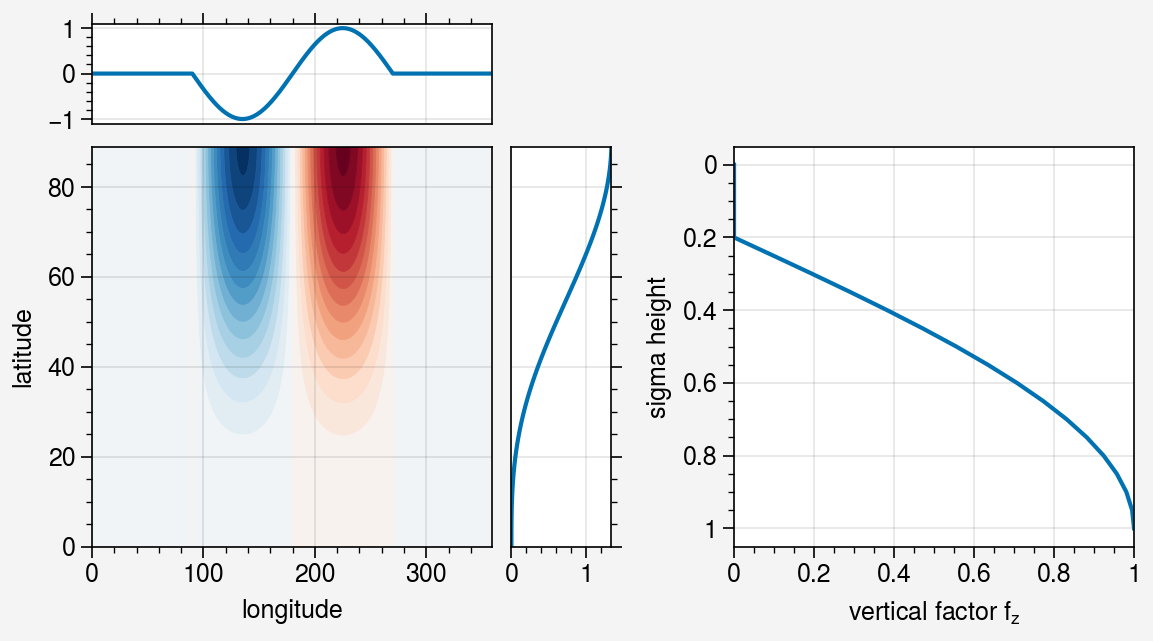

In [4]:
#gs = pplt.GridSpec(nrows=1, ncols=2)
fig = pplt.figure(refwidth=2, share=False)
axs = fig.subplots(nrows=1, ncols=2)

axs[0].contourf(lons, lats, f_xy, levels=30)
p_right = axs[0].panel('right')
p_top = axs[0].panel('top')
p_top.plot(lon_deg, f_x)
p_right.plot(f_y, lat_deg)

axs[1].plot(f_z, sigma)
axs[1].invert_yaxis()

xlabels = ['longitude', 'vertical factor $f_z$']
ylabels = ['latitude', 'sigma height']
for i, ax in enumerate(axs):
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel(ylabels[i])

#fig.savefig(f'gerber_and_vallis_ocean_perturbation.{plot_format}')

### Visualization of HS and PK setups and forcings - see Garny et al. 2020

In [5]:
#@interact(T1=(250,350), gammapk=(0, 10))

forcing_params = Forcing_params()
params = Params_HS_PK()

def adjust_compute_plot(T1=(315), setup='HS', gammapk=(2), eps_abs=(10), l0=(0)):
    params = Params_HS_PK()
    params.T1 = T1
    params.gammapk = gammapk
    params.eps_abs = eps_abs
    params.l0 = l0
    
    t_eq = relax_submodel(setup, lat_rad, plev, p=params)
    
    fig, ax = pplt.subplots()
    if setup == 'HS' or 'SW':
        t_min, t_max = params.T0, params.T1
    elif setup == 'PK':
        t_min, t_max = params.T0 - params.gammapk * 60, params.T1
        #ax.set_yscale('log')
    else:
        raise NotImplementedError
    
    r_air = 287
    cp = 1003
    theta = (t_eq.T * (101300/plev) ** (r_air/cp)).T

    ax.contourf(lat, plev/100, t_eq, levels=np.arange(t_min, t_max+1, 10),  cmap = 'thermal',  colorbar='r')
    #ax.contourf(lat, plev/100, theta, levels=np.arange(240, 400, 10),  cmap = 'thermal',  colorbar='r')
    #ax.contour(lat, plev/100, t_eq_HS, levels=np.arange(t_min, t_max, 10), color='k', labels=True, precision=2, lw=1)
    ax.set_xlabel('Latitude [°N]')
    ax.set_ylabel('Pressure [hPa]')
    #ax.set_yticks([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
    if save_fig:
        fig.save(f't_eq_{setup}_setup.{plot_format}')
   

In [6]:
lat = np.arange(-90,90.1,0.5)
lat_rad = np.radians(lat)

lon = np.arange(0, 360, 2.5)
lon_rad = np.radians(lon)

#plev = np.arange(0.01, 1001, 10) * 100 
plev = np.linspace(np.log(0.001 * 100), np.log(1000 * 100 ), 1000) 
plev = np.exp(plev)
plev = np.flipud(plev)
setup='SW'
save_fig=False

In [7]:
setup='SW'
interact_manual(adjust_compute_plot, setup=setup, T1=FloatSlider(value=320 ,min=250, max=350), 
                gammapk=FloatSlider(value=2, min=0, max=10), eps_abs=FloatSlider(value=10, min=0, max=50),
                l0=FloatSlider(value=0, min=-20, max=20))

interactive(children=(FloatSlider(value=320.0, description='T1', max=350.0, min=250.0), Text(value='SW', descr…

<function __main__.adjust_compute_plot(T1=315, setup='HS', gammapk=2, eps_abs=10, l0=0)>

In [8]:
setup='HS'
interact_manual(adjust_compute_plot, setup=setup, T1=FloatSlider(value=315 ,min=250, max=350), 
                gammapk=FloatSlider(value=2, min=0, max=10), eps_abs=FloatSlider(value=10, min=0, max=50),
                l0=FloatSlider(value=0, min=-20, max=20))

interactive(children=(FloatSlider(value=315.0, description='T1', max=350.0, min=250.0), Text(value='HS', descr…

<function __main__.adjust_compute_plot(T1=315, setup='HS', gammapk=2, eps_abs=10, l0=0)>

In [9]:
setup='PK'
interact_manual(adjust_compute_plot, setup=setup, T1=FloatSlider(value=315 ,min=250, max=350), 
                gammapk=FloatSlider(value=2, min=0, max=10), eps_abs=FloatSlider(value=10, min=0, max=50))

interactive(children=(FloatSlider(value=315.0, description='T1', max=350.0, min=250.0), Text(value='PK', descr…

<function __main__.adjust_compute_plot(T1=315, setup='HS', gammapk=2, eps_abs=10, l0=0)>

In [10]:
q_tropics = ttec_cc_tropics(lat, plev)
q_tropics.plot(ylim=[100000, 100])

NameError: name 'ttec_cc_tropics' is not defined

pbot to achieve max heating at surface: 142857.14285714287


/home/b/b381739/.local/lib/python3.9/site-packages/xarray/core/indexing.py:199: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(label_value, method=method, tolerance=tolerance)
/home/b/b381739/.local/lib/python3.9/site-packages/xarray/core/indexing.py:199: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(label_value, method=method, tolerance=tolerance)
/home/b/b381739/.local/lib/python3.9/site-packages/xarray/core/indexing.py:199: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(label_value, method=method, tolerance=tolerance)
/home/b/b381739/.local/lib/python3.9/site-packages/xarray/plot/plot.py

total sum over forcing: <xarray.DataArray ()>
array(-8.39452396e-20)


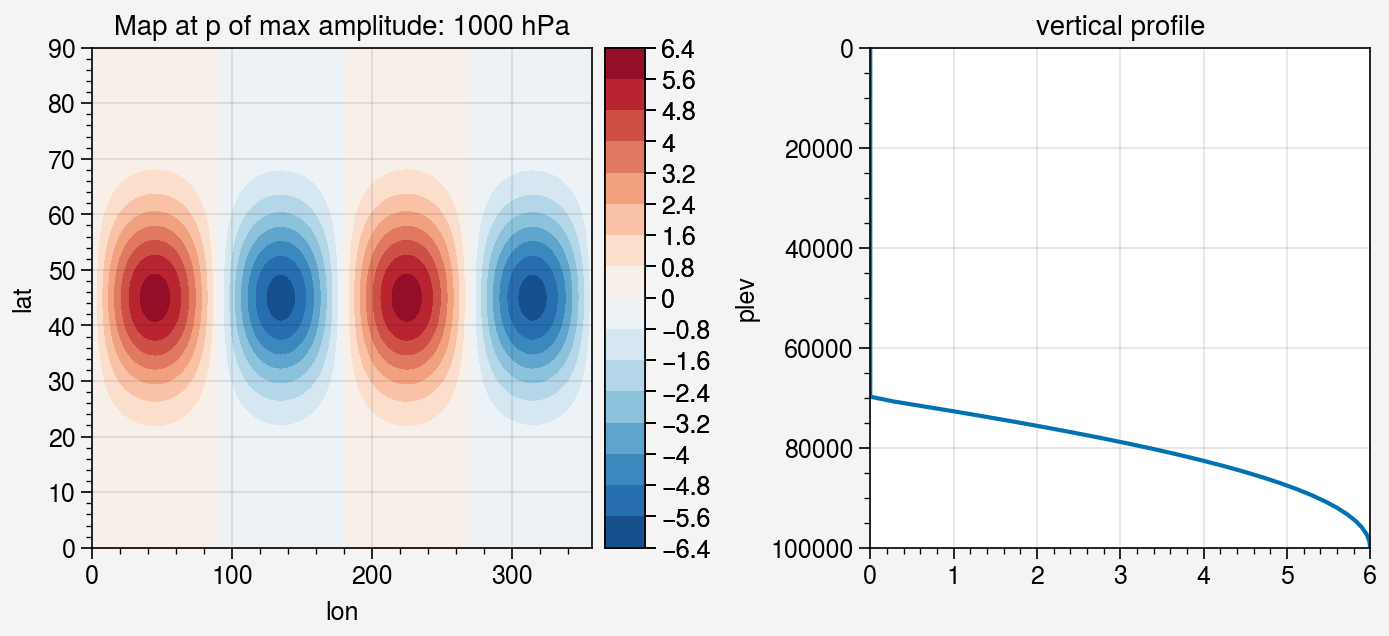

In [12]:
forcing_params.p_top = 70000
forcing_params.p_bot = 100000**2/forcing_params.p_top
forcing_params.q0 = 6
forcing_params.phi0 = 45 
forcing_params.sigma_phi = 0.2
forcing_params.m_WN = 2


print(f'pbot to achieve max heating at surface: {forcing_params.p_bot}')

q_waves = tteh_waves(lon, lat, plev, fp=forcing_params)
fig, ax = wave_forcing_visualization(q_waves, forcing_params)
ax[0].set_ylim([0,90])
fig.savefig(f'wave_forcing_{int(forcing_params.p_top/100)}.{plot_format}')

In [ ]:
forcing_params.ptop = 30000
forcing_params.pbot = 100000**2/forcing_params.ptop
forcing_params.lond = 30
forcing_params.latd = 35
forcing_params.lat0 = 45


q_monsoon = tteh_mons(lon, lat, plev)

monsoon_forcing_visualization(q_monsoon, forcing_params)

In [ ]:
lat = np.arange(-90,90.1,0.5)
lat_rad = np.radians(lat)

lon = np.arange(0, 360, 2.5)
lon_rad = np.radians(lon)

#plev = np.arange(0.01, 1001, 10) * 100 
plev = np.linspace(np.log(0.001 * 100), np.log(1000 * 100 ), 1000) 
plev = np.exp(plev)
plev = np.flipud(plev)
setup='SW'

r_air = 287
g = 9.81
t_equ = relax_submodel('SW', lat_rad, plev)
t_equ = xr.DataArray(t_equ, dims=['plev', 'lat'],
                          coords=dict(lat = (['lat'], lat),
                                      plev= (['plev'], plev/100)))

R = 287.0 # J kg^-1 K^-1
t_i = (t_equ.isel(plev=slice(1,t_equ.plev.size)).values + t_equ.isel(plev=slice(0,t_equ.plev.size-1)))/2
p_i = (t_equ.plev.isel(plev=slice(1,t_equ.plev.size)).values + t_equ.plev.isel(plev=slice(0,t_equ.plev.size-1)))/2
dp = t_equ.plev[1:] - t_equ.plev.values[:-1]
gp = (- R*t_i/p_i * dp ).cumsum(dim='plev')
(gp/g).sel(plev=slice(1000,200)).plot()
plt.ylim([1013,200])

(1000.0, 1.0)

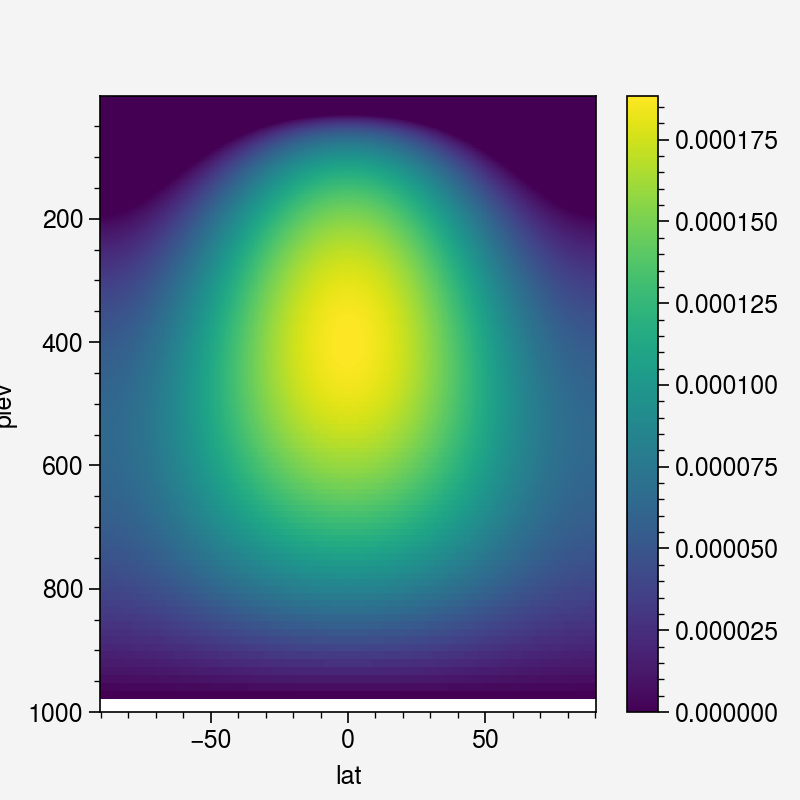

In [51]:
forcing_params.fgamma = 0.5
q_conv = moist_convection(t_equ.isel(plev=slice(2,1000)).values, lat_rad, plev[2:]/100, (gp/g).values)
q_conv.transpose('plev','lat').plot()
plt.ylim([1000,1])

(1000.0, 1.0)

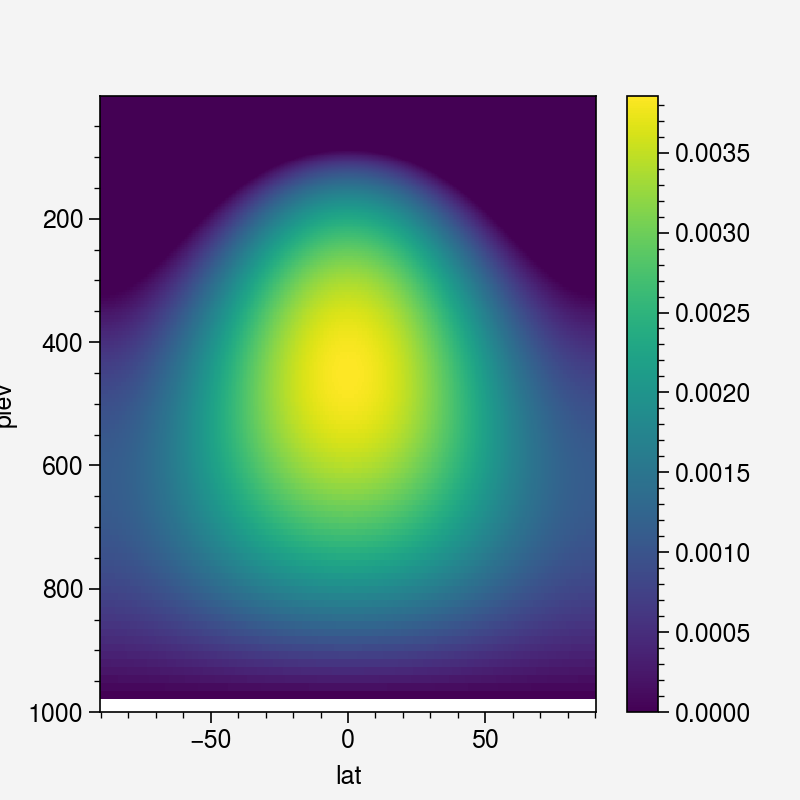

In [52]:
forcing_params.fgamma = 0.7
forcing_params.tc = 0.16
q_conv = moist_convection(t_equ.isel(plev=slice(2,1000)).values, lat_rad, plev[2:]/100, (gp/g).values)
q_conv.transpose('plev','lat').plot()
plt.ylim([1000,1])

In [23]:
theta

<xarray.DataArray (plev: 1000, lat: 361)>
array([[  254.13427805,   254.13875186,   254.15217198, ...,
          254.15217198,   254.13875186,   254.13427805],
       [  253.28110253,   253.28547688,   253.29859863, ...,
          253.29859863,   253.28547688,   253.28110253],
       [  252.46630034,   252.47057562,   252.48340024, ...,
          252.48340024,   252.47057562,   252.46630034],
       ...,
       [10376.41676728, 10376.41676728, 10376.41676728, ...,
        10376.41676728, 10376.41676728, 10376.41676728],
       [10417.55914516, 10417.55914516, 10417.55914516, ...,
        10417.55914516, 10417.55914516, 10417.55914516],
       [10458.86465212, 10458.86465212, 10458.86465212, ...,
        10458.86465212, 10458.86465212, 10458.86465212]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * plev     (plev) float64 1e+03 986.3 972.7 959.4 ... 0.001028 0.001014 0.001

/project/meteo/work/Pablo.Conrat/masterarbeit/lib/python3.9/site-packages/xarray/plot/plot.py:1426: ProplotWarning: Ignoring levels=[240. 248. 256. 264. 272. 280. 288. 296. 304. 312. 320. 328. 336. 344.
 352.]. Instead using norm=<matplotlib.colors.BoundaryNorm object at 0x7fcfde343ca0> boundaries.
  primitive = ax.contourf(x, y, z, **kwargs)


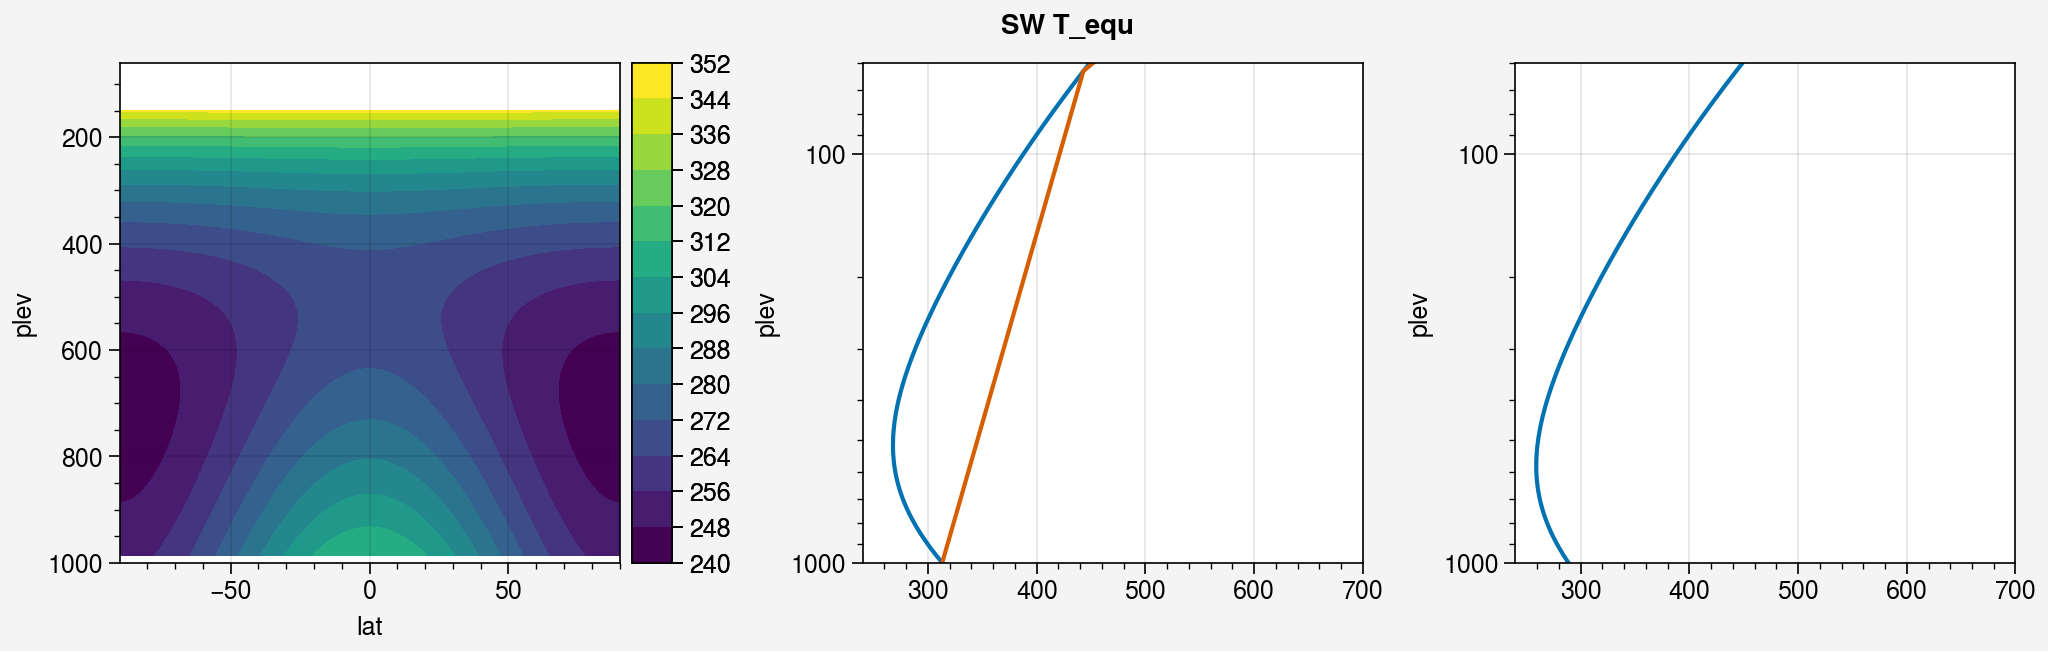

In [28]:
t_equ = relax_submodel('SW', lat_rad, plev)
t_equ = xr.DataArray(t_equ, dims=['plev', 'lat'],
                          coords=dict(lat = (['lat'], lat),
                                      plev= (['plev'], plev/100)))
r_air = 287
cp = 1003
theta = (t_equ.T * (101300/plev) ** (r_air/cp)).T

fig, ax = pplt.subplots(ncols=3, share=False, figtitle='SW T_equ')
theta.sel(plev=slice(1000, 150)).plot.contourf(ax=ax[0], levels=15)
ax[1].plot(theta.sel(lat=0, method='nearest'),
           t_equ.plev)
ax[2].plot(theta.sel(lat=40, method='nearest'),
           t_equ.plev)

ax[1].plot(theta.sel(lat=0, method='nearest').values[::200], t_equ.plev.values[::200])
t_equ_sel = t_equ.sel(lat=0, method='nearest')
#ax[1].plot((t_equ.dropna('plev').isel(plev=-1).values - 0.7 * 0.0098 * z) * (p00/t_equ.plev) ** (r_air/cp), t_equ.plev)

for a in ax:
    a.set_ylim([1000,60])
ax[1].set_xlim([240, 700])
ax[2].set_xlim([240, 700])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
#fig.save(f'{exp_name}_theta_cmp.{plot_format}')

In [89]:
t_equ.sel(lat=90)

<xarray.DataArray (plev: 1000)>
array([264.00524561, 262.96415569, 261.92717124, 260.89427608,
       259.86545409, 258.8406892 , 257.81996541, 256.80326679,
       255.79057747, 254.78188163, 253.77716352, 252.77640746,
       251.77959783, 250.78671907, 249.79775566, 248.81269218,
       247.83151323, 246.85420352, 245.88074777, 244.91113078,
       243.94533743, 242.98335263, 242.02516137, 241.07074867,
       240.12009965, 239.17319946, 238.23003332, 237.29058651,
       236.35484434, 235.42279223, 234.49441561, 233.56969999,
       232.64863094, 231.73119407, 230.81737506, 229.90715964,
       229.00053361, 228.09748281, 227.19799314, 226.30205056,
       225.40964107, 224.52075075, 223.63536573, 222.75347216,
       221.8750563 , 221.00010442, 220.12860286, 219.26053802,
       218.39589635, 217.53466434, 216.67682856, 215.8223756 ,
       214.97129212, 214.12356485, 213.27918055, 212.43812602,
       211.60038815, 210.76595385, 209.93481009, 209.1069439 ,
       208.28234236, 207.46099259, 206.64288176, 205.82799711,
       205.01632591, 204.20785549, 203.40257323, 202.60046655,
       201.80152294, 201.00572992, 200.21307506, 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
...
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ,
       200.        , 200.        , 200.        , 200.        ])
Coordinates:
    lat      float64 90.0
  * plev     (plev) float64 1e+03 986.3 972.7 959.4 ... 0.001028 0.001014 0.001

/home/p/Pablo.Conrat/.local/lib/python3.9/site-packages/xarray/plot/plot.py:1420: ProPlotWarning: Ignoring levels=[270.0, 275.0, 280.0, 285.0, 290.0, 295.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0, 335.0, 340.0, 345.0, 350.0, 355.0, 360.0, 365.0, 370.0]. Instead using norm=<matplotlib.colors.BoundaryNorm object at 0x7f52eb837820> boundaries.
  primitive = ax.contourf(x, y, z, **kwargs)


(270.0, 380.0)

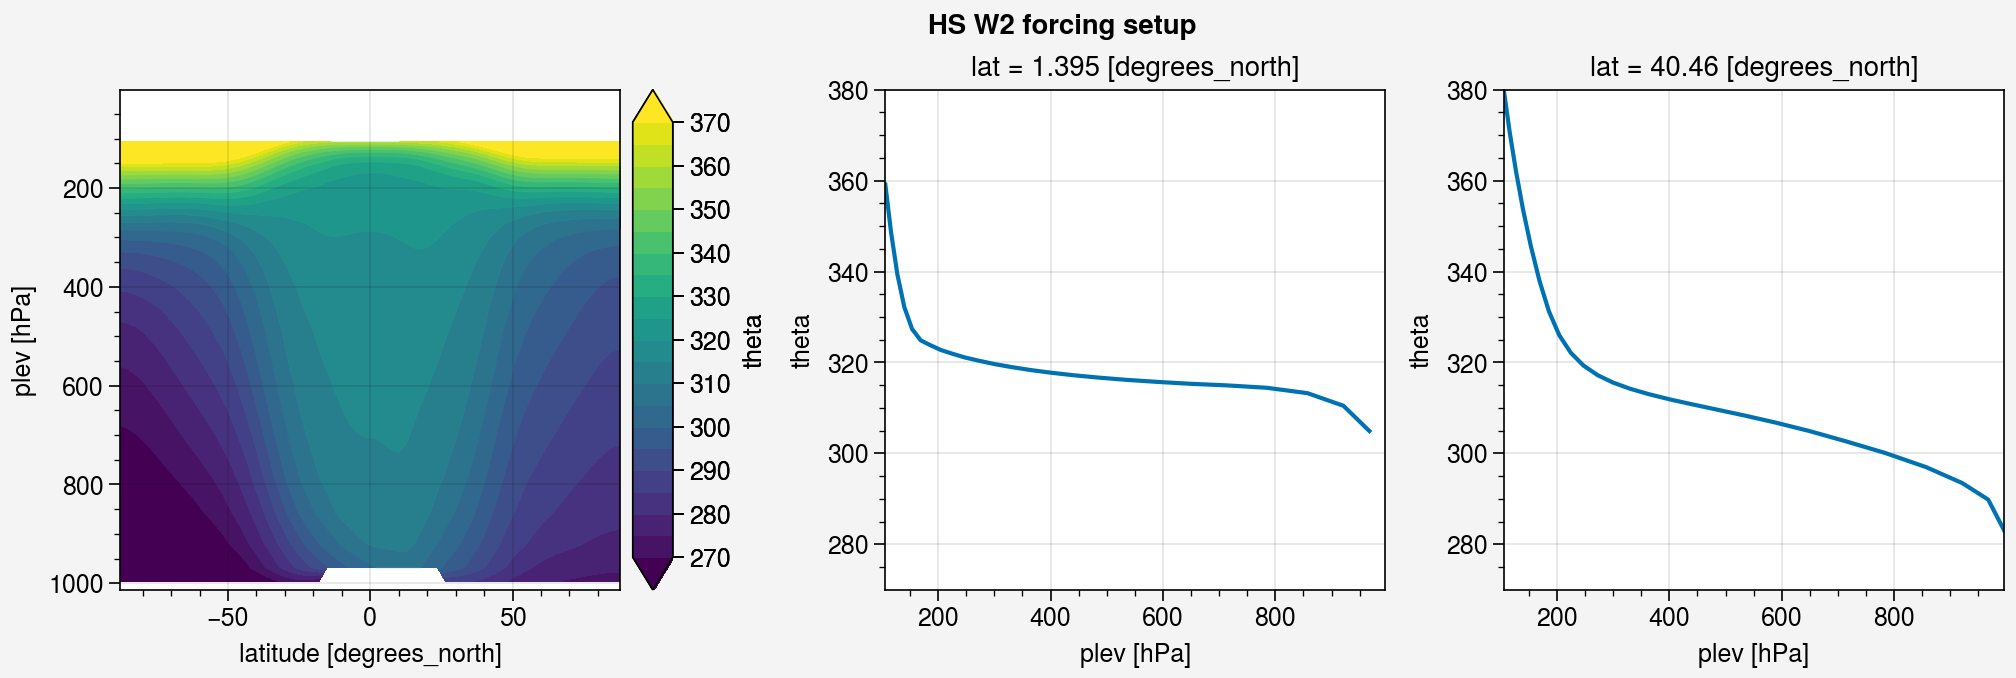

In [82]:
exp_name = 'EMIL_HS_l6_w00'
ds_zm = xr.open_dataset(f'{exp_name}/{exp_name}_zm_pp.nc').sortby('time')
ds_zm['theta'] = (ds_zm.tm1 * (1013/ds_zm.plev) ** (r_air/cp))

fig, ax = pplt.subplots(ncols=3, share=False, figtitle='HS W2 forcing setup')
ds_zm.theta.sel(plev=slice(100,1000)).mean('time').plot.contourf(ax=ax[0], levels=np.arange(270,370.1,5))
ax[0].set_ylim(ylims)
#fig.save('um1_clim.png')
ds_zm.theta.sel(plev=slice(100,1000)).sel(lat=0, method='nearest').mean('time').plot(ax=ax[1])
ds_zm.theta.sel(plev=slice(100,1000)).sel(lat=40, method='nearest').mean('time').plot(ax=ax[2])

ax[1].set_ylim([270, 380])
ax[2].set_ylim([270, 380])


(1000.0, 100.0)

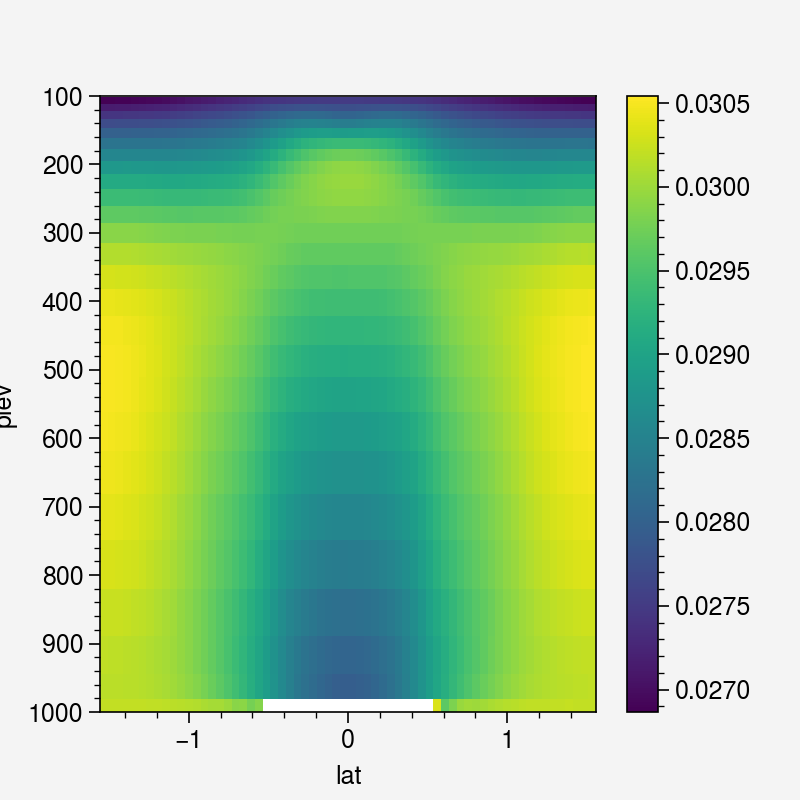

In [46]:
forcing_params.fgamma = 0.7
forcing_params.tc = 0.16
q_conv = moist_convection(ds_zm.tm1.mean('time').values, np.radians(ds_zm.lat.values), ds_zm.plev.values, ds_zm.geopot_p.mean('time').values/g)
q_conv.sel(plev=slice(100,1000)).transpose('plev','lat').plot()
plt.ylim([1000,100])

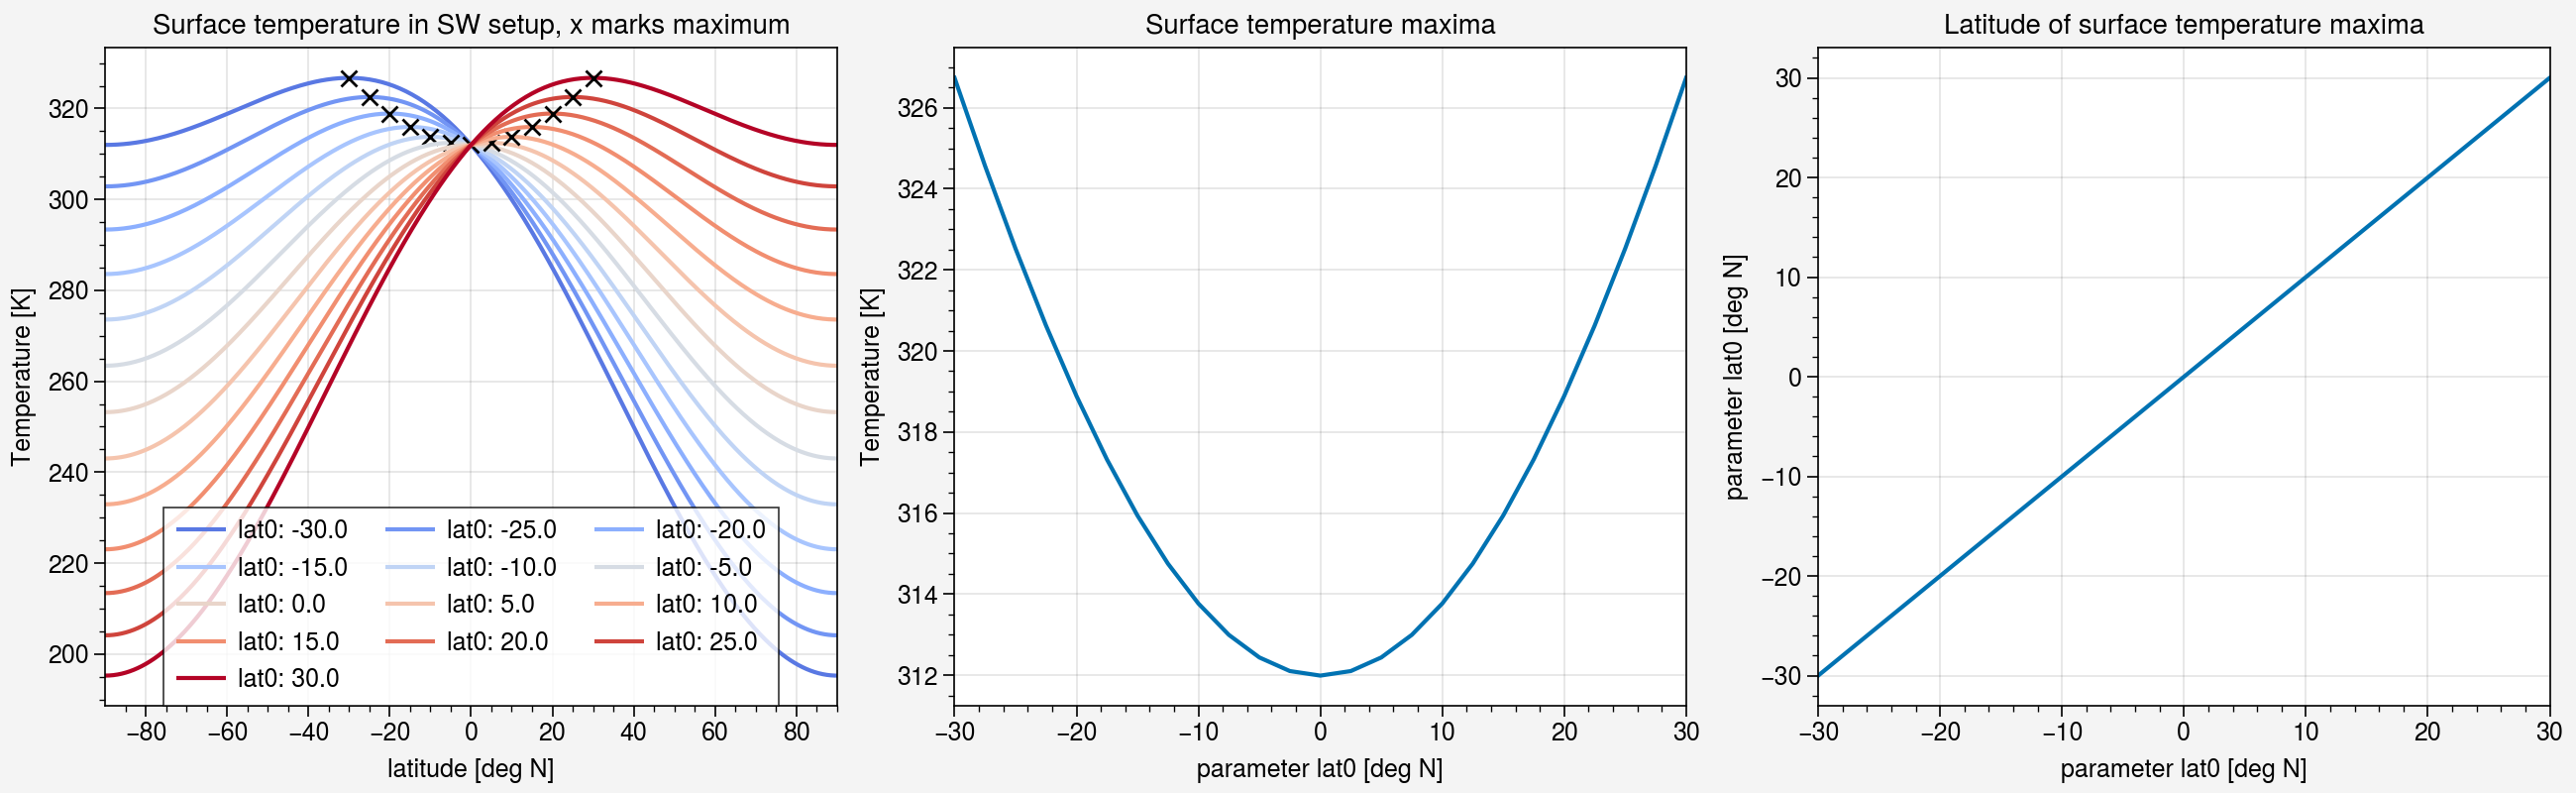

In [8]:
lat = np.arange(-90,90.1,0.5)
lat_rad = np.radians(lat)
setup='SW'


cycle = pplt.Cycle('coolwarm', 13, left=0.1)
fig, ax = pplt.subplots(ncols=3, figsize=(13,4), share=False)
ax[0].set_title(f'Surface temperature in {setup} setup, x marks maximum')
ax[1].set_title('Surface temperature maxima')
ax[2].set_title('Latitude of surface temperature maxima')
l0_range = np.arange(-30,30.5,2.5)
max_lats = np.zeros(l0_range.shape)
maxima = np.zeros(l0_range.shape)

for i,l0 in enumerate(l0_range):
    if setup == 'SW':
        params.l0 = l0
    elif setup == 'HS' or 'PK':
        params.eps_abs = np.abs(l0)
        params.hfac = np.sign(l0)
    t_eq = relax_submodel(setup, lat_rad, plev, params)
    index = np.where(t_eq[0,:] == t_eq[0,:].max())
    if l0 % 1.0 == 0:
        ax[0].plot(lat,t_eq[0,:], label=f'lat0: {l0}', cycle=cycle)
        ax[0].plot(lat[index], t_eq[0,index], 'x', color='k')

    maxima[i] = t_eq[0,index]
    max_lats[i] = lat[index]

ax[1].plot(l0_range, maxima)
ax[2].plot(l0_range, max_lats)

ax[0].set_xlabel('latitude [deg N]')
ax[1].set_xlabel('parameter lat0 [deg N]')
ax[2].set_xlabel('parameter lat0 [deg N]')

ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature [K]')
ax[2].set_ylabel('parameter lat0 [deg N]')

#print(f'latitude of maximum: {lat[index]}')
ax[0].legend()
fig.save(f't_eq_{setup}_setup_sfc_temps.{plot_format}')

In [18]:
weights.min()

0.0